Chargement de lstm_best.pt sur cpu...
Architecture forcée : Input=3, Hidden=64, Layers=6
✅ Modèle chargé et poids alignés avec succès.
🏃 Début de la simulation...
--- T=0 ---
Vitesse Réelle: 8.0 -> Norm: 8.0000
FC Actuelle: 120.0 -> Norm: 120.0000
Sortie Modèle: 140.1920
--- T=100 ---
Vitesse Réelle: 9.7 -> Norm: 9.6528
FC Actuelle: 140.2 -> Norm: 140.1920
Sortie Modèle: 140.1920
--- T=200 ---
Vitesse Réelle: 11.3 -> Norm: 11.3222
FC Actuelle: 140.2 -> Norm: 140.1920
Sortie Modèle: 140.1920
--- T=300 ---
Vitesse Réelle: 13.0 -> Norm: 12.9917
FC Actuelle: 140.2 -> Norm: 140.1920
Sortie Modèle: 140.1920
--- T=400 ---
Vitesse Réelle: 14.7 -> Norm: 14.6611
FC Actuelle: 140.2 -> Norm: 140.1920
Sortie Modèle: 140.1920
--- T=500 ---
Vitesse Réelle: 16.3 -> Norm: 16.3306
FC Actuelle: 140.2 -> Norm: 140.1920
Sortie Modèle: 140.1920


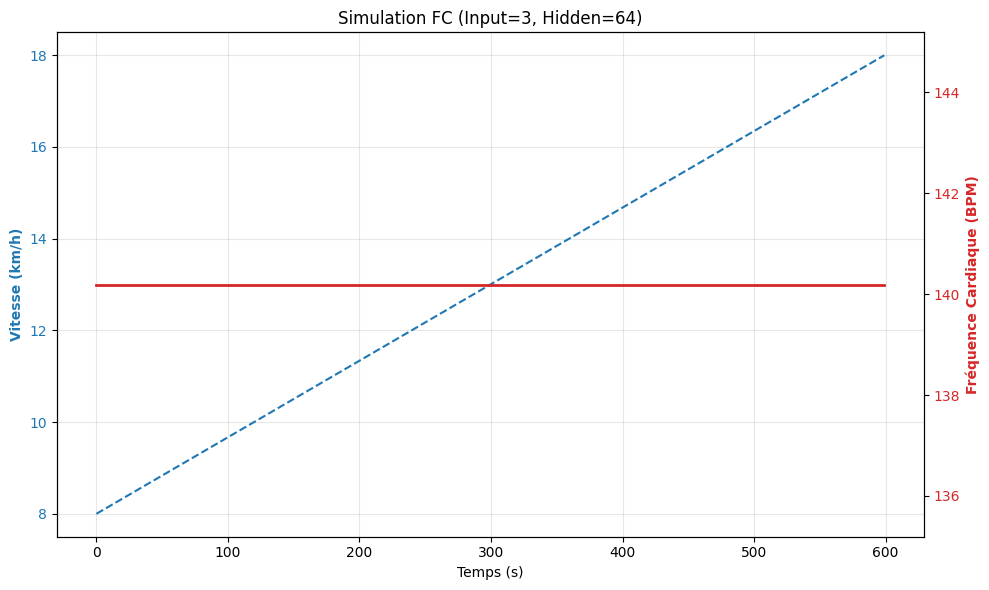

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# --- 1. ARCHITECTURE ---
class HeartRateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(HeartRateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# --- 2. UTILITAIRE DE NORMALISATION ---
class SimulationScaler:
    def __init__(self):
        # Configuration standard pour [Vitesse, Pente, FC]
        # AJUSTEZ CES VALEURS SI VOS PRÉDICTIONS SONT DÉCALÉES
        self.min_val = np.array([0.0,  -10.0, 40.0]) 
        self.max_val = np.array([25.0,  20.0, 200.0])
        
    def transform(self, feature_vector):
        input_data = np.array(feature_vector)
        denom = self.max_val - self.min_val
        denom[denom == 0] = 1.0 
        return (input_data - self.min_val) / denom

    def inverse_transform_target(self, normalized_fc):
        fc_min = self.min_val[2]
        fc_max = self.max_val[2]
        return normalized_fc * (fc_max - fc_min) + fc_min

def valider_modele():
    # --- CONFIGURATION ---
    PATH = 'lstm_best.pt'
    DUREE_SIMULATION = 600
    SEQUENCE_LENGTH = 30
    
    VITESSE_DEPART = 8.0
    VITESSE_FIN = 18.0
    FC_INITIALE = 120
    
    scaler = SimulationScaler()

    # --- CHARGEMENT ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    try:
        print(f"Chargement de {PATH} sur {device}...")
        checkpoint = torch.load(PATH, map_location=device, weights_only=False)
        args = checkpoint['args']
        
        # --- RÉCUPÉRATION DES HYPERPARAMÈTRES ---
        if isinstance(args, dict):
            h_size = args.get('hidden_size', 64)
            n_layers = args.get('num_layers', 2)
            drp = args.get('dropout', 0.2)
        else:
            h_size = args.hidden_size
            n_layers = args.num_layers
            drp = args.dropout

        # --- CORRECTION CRITIQUE ICI ---
        # L'erreur indique que les poids attendent 3 entrées, pas 16.
        # On force donc input_size à 3 (Vitesse, Pente, FC)
        i_dim = 3 
            
        print(f"Architecture forcée : Input={i_dim}, Hidden={h_size}, Layers={n_layers}")

        model = HeartRateLSTM(input_size=i_dim, hidden_size=h_size, num_layers=n_layers, dropout=drp)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        model.eval()
        print(f"✅ Modèle chargé et poids alignés avec succès.")
        
    except FileNotFoundError:
        print(f"❌ Erreur : Le fichier {PATH} est introuvable.")
        return
    except Exception as e:
        print(f"❌ Erreur critique : {e}")
        return

    # --- DONNÉES SCÉNARIO ---
    temps = np.arange(DUREE_SIMULATION)
    acceleration = np.linspace(VITESSE_DEPART, VITESSE_FIN, DUREE_SIMULATION)
    pente = np.zeros(DUREE_SIMULATION)

    predictions_fc = []
    
    history_buffer = deque(maxlen=SEQUENCE_LENGTH)
    current_hr = FC_INITIALE

    # Warm-up buffer
    for _ in range(SEQUENCE_LENGTH):
        # On crée un vecteur de taille i_dim (donc 3)
        features = [VITESSE_DEPART, 0.0, current_hr]
        history_buffer.append(features)

    print("🏃 Début de la simulation...")

    with torch.no_grad():
        for t in range(DUREE_SIMULATION):
            # 1. Normalisation
            raw_seq = np.array(history_buffer)
            #norm_seq = np.array([scaler.transform(x) for x in raw_seq])
            norm_seq = np.array(history_buffer)
                
            # Vérification de sécurité dimensionnelle
            if norm_seq.shape[1] != i_dim:
                print(f"Erreur de dimension: attendu {i_dim}, reçu {norm_seq.shape[1]}")
                break

            input_tensor = torch.FloatTensor(norm_seq).unsqueeze(0).to(device)

            # 2. Prédiction
            pred_norm = model(input_tensor).item()

            # 3. Dénormalisation
            nouvelle_fc = pred_norm
            
            if t % 100 == 0:
                print(f"--- T={t} ---")
                print(f"Vitesse Réelle: {acceleration[t]:.1f} -> Norm: {norm_seq[-1][0]:.4f}")
                print(f"FC Actuelle: {current_hr:.1f} -> Norm: {norm_seq[-1][2]:.4f}")
                print(f"Sortie Modèle: {pred_norm:.4f}")
            # Lissage (optionnel)
            # nouvelle_fc = current_hr * 0.2 + nouvelle_fc * 0.8
            pass 
        
            predictions_fc.append(nouvelle_fc)
            current_hr = nouvelle_fc

            # 4. Mise à jour Buffer
            new_features = [acceleration[t], pente[t], current_hr]
            history_buffer.append(new_features)

    # --- VISUALISATION ---
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel('Temps (s)')
    ax1.set_ylabel('Vitesse (km/h)', color=color, fontweight='bold')
    ax1.plot(temps, acceleration, color=color, linestyle='--', label='Vitesse')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Fréquence Cardiaque (BPM)', color=color, fontweight='bold')
    ax2.plot(temps, predictions_fc, color=color, linewidth=2, label='FC Prédite')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Ajustement des échelles pour lisibilité
    ax2.set_ylim(bottom=min(predictions_fc)-5, top=max(predictions_fc)+5)
    
    plt.title(f"Simulation FC (Input={i_dim}, Hidden={h_size})")
    fig.tight_layout()
    plt.show()

if __name__ == "__main__":
    valider_modele()